<a href="https://colab.research.google.com/github/yeachanyun/AutoTradingSystem/blob/master/%EC%9C%A4%EC%98%88%EC%B0%AC/Prediction_of_Stock_Data_and_Result_Charts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import utils

from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

import pandas_datareader.data as web

import matplotlib.pyplot as plt

In [2]:
def get_stock_data(
      code
    , start_date
    , end_date
    ):
    """
    Retrieves stock dataframe using yahoo finance 
    and saves to csv.

    - :param code: the ticker symbol
      * example: '000000.KS' / '000000.KQ' / 'ABCD'
      * KS = KOSPI, KQ = KOSDAQ
    - :param start_date: start datetime of stock data
    - :param end_date: end datetime of stock data
    """
    stock_df = web.DataReader(
        '%s' % code
        , 'yahoo'
        , start_date
        , end_date
    )
    
    stock_df.to_csv('%s.csv' % code)

    return stock_df

In [4]:
def make_dataset(data, label, window_size=20):  # Hyperparameter
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i + window_size]))
        label_list.append(np.array(label.iloc[i + window_size]))
    return np.array(feature_list), np.array(label_list)

In [5]:
stock_df = get_stock_data(
    '005930.KS'
    , '2000-01-01'
    , '2020-10-01'
)

In [6]:
scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df_scaled = scaler.fit_transform(stock_df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(df_scaled)

          Open      High       Low     Close    Volume
0     0.058190  0.055796  0.054656  0.056645  0.451816
1     0.054827  0.054963  0.052294  0.047763  0.454770
2     0.053986  0.050300  0.053306  0.048433  0.331212
3     0.050790  0.048468  0.049595  0.047092  0.245440
4     0.051463  0.050133  0.053306  0.050947  0.285479
...        ...       ...       ...       ...       ...
5203  0.939455  0.933378  0.927463  0.936316  0.122470
5204  0.927682  0.930047  0.930837  0.922909  0.106957
5205  0.927682  0.923384  0.932524  0.924585  0.069693
5206  0.937773  0.933378  0.935897  0.929613  0.076814
5207  0.937773  0.936709  0.940958  0.929613  0.094410

[5208 rows x 5 columns]


In [9]:
################# LSTM Networks #################
tf.random.set_seed(0)

feature_cols = ['Open', 'High', 'Low', 'Volume']  # the question
label_cols = ['Close']  # the answer
TEST_SIZE = 200  # the number of past days for the question

train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

train_feature = train[feature_cols]
train_label = train[label_cols]
test_feature = test[feature_cols]
test_label = test[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, 20)
test_feature, test_label = make_dataset(test_feature, test_label, 20)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2, random_state=0)

# time order doesn't matter on neural networks
utils.shuffle(x_train, y_train, random_state=0)

print(x_train.shape)
print(x_valid.shape)

(3990, 20, 4)
(998, 20, 4)


In [23]:
model = Sequential()
# cannot add more than 1 LSTM layer
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False) # dropout is not recommended
          )
model.add(Dense(1))  

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 16)                1344      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,361
Trainable params: 1,361
Non-trainable params: 0
_________________________________________________________________


In [24]:
filename = os.path.join('tmp_checkpoint.h5')

early_stop = EarlyStopping(monitor='val_loss', patience=20)
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, batch_size=16, epochs=400, validation_data=(x_valid, y_valid), callbacks=[early_stop, checkpoint]) 

Epoch 1/400
248/250 [============================>.] - ETA: 0s - loss: 0.0143
Epoch 00001: val_loss improved from inf to 0.00024, saving model to tmp_checkpoint.h5
250/250 [==============================] - 2s 9ms/step - loss: 0.0142 - val_loss: 2.3712e-04
Epoch 2/400
246/250 [============================>.] - ETA: 0s - loss: 1.7265e-04
Epoch 00002: val_loss improved from 0.00024 to 0.00014, saving model to tmp_checkpoint.h5
250/250 [==============================] - 2s 8ms/step - loss: 1.7206e-04 - val_loss: 1.3727e-04
Epoch 3/400
248/250 [============================>.] - ETA: 0s - loss: 1.3431e-04
Epoch 00003: val_loss improved from 0.00014 to 0.00013, saving model to tmp_checkpoint.h5
250/250 [==============================] - 2s 8ms/step - loss: 1.3445e-04 - val_loss: 1.3358e-04
Epoch 4/400
246/250 [============================>.] - ETA: 0s - loss: 1.3133e-04
Epoch 00004: val_loss did not improve from 0.00013
250/250 [==============================] - 2s 8ms/step - loss: 1.3241e-0

In [25]:
model.load_weights(filename)
pred = model.predict(test_feature)  # the quiz

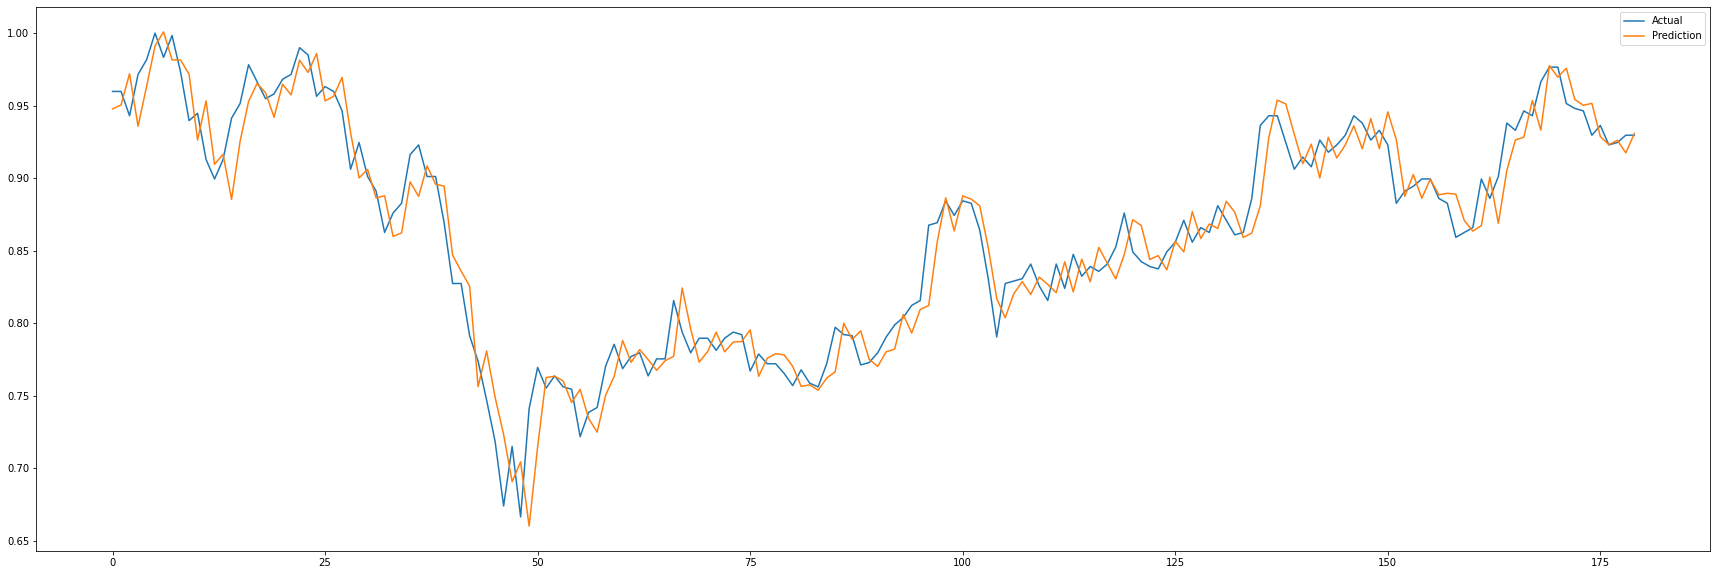

In [26]:
plt.figure(figsize=(30,10))
plt.plot(test_label, label='Actual')
plt.plot(pred, label='Prediction')
plt.legend()
plt.show()